In [1]:
#packages
using Pkg #package manager
Pkg.activate(".") #applies any following packages to this directory

  Activating project at `~/Projects/Indistinguishability-Repo`


In [2]:
#Relevant packages
using Catalyst;
using MomentClosure;
using DifferentialEquations;
using Sundials;
using LinearAlgebra;
using CairoMakie;
using GLM;
using StatsBase;
using DataFrames;
using Latexify;
using Colors;
using CSV;
using XLSX;
using LsqFit;
using BlackBoxOptim;
using SpecialFunctions;

In [3]:
oorange = colorant"#FF8A4E"

In [4]:
ooorange = RGBAf(255/255,138/255,78/255,0.7)

In [5]:
ppurple = colorant"#9D02D7"

In [6]:
pppurple = RGBAf(157/255,2/255,215/255,0.5)

In [7]:
bbblue = RGBAf(0,0,255/255,0.5)

In [8]:
bblue = RGBAf(0,0,255/255,1)

In [9]:
yyyellow = RGBAf(255/255,215/255,0,0.5)

In [10]:
yyellow = RGBAf(255/255,215/255,0,1)

In [11]:
rrred = RGBAf(255/255,0,0,0.5)

In [12]:
#function to compute the predicted values given by a specified regression model for specified parameters and range
function compute_mean_reg(model_func, params, x_range)
    y_vec = Vector{Float64}();
    for x in x_range
        y = model_func(x, params);
        push!(y_vec, y);
    end
    return y_vec;
end

compute_mean_reg (generic function with 1 method)

In [14]:
#Import each mean induction curve

#vector to store the name of each data file
mean_filename_vec = Vector{String}();
bootstrap_filename_vec = Vector{String}();
for marker in ["CY5", "TMR"]
    for Exp in ["1", "2"]
        for species in ["nuclear", "cytoplasm"]
            mean_filename = "scData_Exp"*string(Exp)*"_"*string(marker)*"_"*string(species)*".xlsx";
            bootstrap_filename = "BootstrapMeans_Exp"*string(Exp)*"_"*string(marker)*"_"*string(species)*".xlsx";
            push!(mean_filename_vec, mean_filename);
            push!(bootstrap_filename_vec, bootstrap_filename);
        end
    end
end

#compute means from single cell data
mean_t_vec = Vector{Vector{Float64}}(); #vector to contain mRNA means
@time for filename in mean_filename_vec
    df_data = DataFrame(XLSX.readtable(filename, "Sheet1"));
    #compute mean for each time point
    temp_mean_t_vec = Vector{Float64}();
    for i in 1:1:(size(df_data)[2])-1
        len = length(df_data[:,i]);
        notmissing_idxs = findall(x -> ismissing(df_data[:,i][x])==false, collect(1:1:len))
        temp_mean = mean(df_data[notmissing_idxs,i]);
        push!(temp_mean_t_vec, temp_mean);
    end
    #save means in vector
    push!(mean_t_vec, temp_mean_t_vec);
end
#separate cytoplasmic and nuclear means
cytoplasm_means_vec_all = mean_t_vec[[2, 4, 6, 8]];
nuclear_means_vec_all = mean_t_vec[[1, 3, 5, 7]];

#times
times_vec = [0.0, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 15.0];

 13.164759 seconds (25.83 M allocations: 19.644 GiB, 39.34% gc time, 37.88% compilation time)


In [15]:
#computing standard errors in means for plotting

#vectors to store nuclear and cytoplasmic mRNA std errors in means
means_stderr_vec_all = Vector{Vector{Float64}}();

for filename in bootstrap_filename_vec
    
    #import bootstrap results
    df_bootstrap_mean = DataFrame(XLSX.readtable(filename, "Sheet1"));
    n_cols = size(df_bootstrap_mean)[2];
    
    #compute variance and std dev of mean at each time point (compute standard error)
    means_stderr_vec = Vector{Float64}();
    for i in 1:1:n_cols
        std_err = sqrt(var(df_bootstrap_mean[:,i]));
        push!(means_stderr_vec, std_err);
    end
    push!(means_stderr_vec_all, means_stderr_vec);
    
end
cytoplasm_stderr_vec_all = means_stderr_vec_all[[2, 4, 6, 8]];
nuclear_stderr_vec_all = means_stderr_vec_all[[1, 3, 5, 7]];

In [16]:
#estimate parameters from each of the mean mRNA count curves

#vector to store the number of time points to use in regression
N_timepoints_vec_all = [5, 6, 7, 7, 6, 6, 7, 7];
N_timepoints_vec_nuclear = N_timepoints_vec_all[[1, 3, 5, 7]];
N_timepoints_vec_cytoplasm = N_timepoints_vec_all[[2, 4, 6, 8]];
#vector to store the upper bound of the delay for different curves
delay_UB_vec = [4.0, 5.0, 4.0, 5.0];

#store results of regression (optimal parameters and regression curves)
optimal_params_nuclear_all = Vector{Vector{Float64}}();
optimal_params_cytoplasm_all = Vector{Vector{Float64}}();
nuclear_mean_reg_all = Vector{Vector{Float64}}();
cytoplasm_mean_reg_all = Vector{Vector{Float64}}();
x_range_N_all = Vector{Vector{Float64}}();
x_range_C_all = Vector{Vector{Float64}}();

ii = 1; #should range from 1-4, for each of the 4 nuclear and cytoplasmic curves

#estimate parameters for regression in curve plots
@time for i in 1:2:7

    #fit cytoplasmic
    #define full cyoplasmic mRNA model
    function m_C(t, p)
        if t < p[3]
            return p[4];
        else
            return p[4] + (p[1]/gamma(p[2]))*((t-p[3]).^p[2]);
        end
    end
    #p[1] - prefactor - A_C
    #p[2] - exponent - n_C
    #p[3] - delay - t_0
    #p[4] - constant cytoplasmic mRNA during delay m0_C

    #define beforehand
    x_ = times_vec[1:N_timepoints_vec_all[i+1]];
    y_ = cytoplasm_means_vec_all[ii][1:N_timepoints_vec_all[i+1]];
    model_func = m_C;

    #construct a function which computes the RSS for a given set of model parameters
    #the covariates (x_), responses (y_) and regression model (model_func) all need to be predefined
    #pass function a vector of model parameters (p_vec)
    function RSS_cytoplasm(p_vec)

        #compute predicted values
        y_pred = Vector{Float64}();
        for i in 1:1:length(y_)
            temp_pred = model_func(x_[i], p_vec);
            push!(y_pred, temp_pred);
        end

        #compute residuals
        resid = Vector{Float64}();
        for i in 1:1:length(y_)
            temp_resid = y_[i] - y_pred[i];
            push!(resid, temp_resid);
        end

        #compute residual sum of squares (RSS)
        rss_value = sum(resid .^ 2);

        return rss_value;

    end

    #Optimisation!

    #p[1] - prefactor - A_C
    #p[2] - exponent - n_C
    #p[3] - delay - t_0
    #p[4] - constant cytoplasmic mRNA during delay - m0_C
    optim_res_C = bboptimize(RSS_cytoplasm; SearchRange = [(0.0, 10^3), (1.0, 10.0), (0.0, delay_UB_vec[ii]), (0.0, 1.5)], MaxSteps=5*10^5, TraceMode=:silent);

    #extract delay
    t_0 = best_candidate(optim_res_C)[3];

    #define full nuclear mRNA model
    function m_N(t, p)
        if t < t_0
            return p[3];
        else
            return p[3] + (p[1]/gamma(p[2]))*((t-t_0).^p[2]);
        end
    end
    #p[1] - prefactor - A_N
    #p[2] - exponent - n_N
    #p[3] - constant nuclear mRNA during delay - m0_N

    #define beforehand
    x_ = times_vec[1:N_timepoints_vec_all[i]];
    y_ = nuclear_means_vec_all[ii][1:N_timepoints_vec_all[i]];
    model_func = m_N;

    #construct a function which computes the RSS for a given set of model parameters
    #the covariates (x_), responses (y_) and regression model (model_func) all need to be predefined
    #pass function a vector of model parameters (p_vec)
    function RSS_nuclear(p_vec)

        #compute predicted values
        y_pred = Vector{Float64}();
        for i in 1:1:length(y_)
            temp_pred = model_func(x_[i], p_vec);
            push!(y_pred, temp_pred);
        end

        #compute residuals
        resid = Vector{Float64}();
        for i in 1:1:length(y_)
            temp_resid = y_[i] - y_pred[i];
            push!(resid, temp_resid);
        end

        #compute residual sum of squares (RSS)
        rss_value = sum(resid .^ 2);

        return rss_value;

    end

    #Optimisation!

    #p[1] - prefactor - A_C
    #p[2] - exponent - n_C
    #p[3] - constant nuclear mRNA during delay - m0_N
    optim_res_N = bboptimize(RSS_nuclear; SearchRange = [(0.0, 10^3), (1.0, 10.0), (0.0, 0.2)], MaxSteps=10^5, TraceMode=:silent);

    #compute regression
    x_range_N = 0.0:0.1:times_vec[1:N_timepoints_vec_all[i]][end];
    optim_ps_vec_N = best_candidate(optim_res_N);
    nuclear_mean_reg = compute_mean_reg(m_N, optim_ps_vec_N, x_range_N);

    x_range_C = 0.0:0.1:times_vec[1:N_timepoints_vec_all[i+1]][end];
    optim_ps_vec_C = best_candidate(optim_res_C);
    cytoplasm_mean_reg = compute_mean_reg(m_C, optim_ps_vec_C, x_range_C);
    
    push!(optimal_params_nuclear_all, optim_ps_vec_N);
    push!(optimal_params_cytoplasm_all, optim_ps_vec_C);
    push!(nuclear_mean_reg_all, nuclear_mean_reg);
    push!(cytoplasm_mean_reg_all, cytoplasm_mean_reg);
    push!(x_range_N_all, x_range_N);
    push!(x_range_C_all, x_range_C);
    
    ii += 1;
    
end

  9.077982 seconds (92.49 M allocations: 3.038 GiB, 7.11% gc time, 57.98% compilation time)


In [17]:
#import bootstrap results and save to vectors

RSS_C_vec_all = Vector{Vector{Float64}}();
A_C_vec_all = Vector{Vector{Float64}}();
n_C_vec_all = Vector{Vector{Float64}}();
t0_vec_all = Vector{Vector{Float64}}();
m0C_vec_all = Vector{Vector{Float64}}();
Rsq_C_vec_all = Vector{Vector{Float64}}();
RSS_N_vec_all = Vector{Vector{Float64}}();
A_N_vec_all = Vector{Vector{Float64}}();
n_N_vec_all = Vector{Vector{Float64}}();
m0N_vec_all = Vector{Vector{Float64}}();
Rsq_N_vec_all = Vector{Vector{Float64}}();

bootstrap_results_filename_vec = ["YeastData_SampDist_Exp1_CY5.xlsx", "YeastData_SampDist_Exp2_CY5.xlsx",
    "YeastData_SampDist_Exp1_TMR.xlsx", "YeastData_SampDist_Exp2_TMR.xlsx"];

for i in 1:1:length(bootstrap_results_filename_vec)
    
    #filename
    filename = bootstrap_results_filename_vec[i];
    #import bootstrap results
    df_reg_results = DataFrame(XLSX.readtable(filename, "Sheet1"));
    
    #extract results
    if i==2 || i==4
        idx = 15;
    elseif i==1
        idx = 12;
    elseif i==3
        idx = 13;
    end
        RSS_C = convert(Vector{Float64}, df_reg_results[:,idx]); #RSS_C
        A_C = convert(Vector{Float64}, df_reg_results[:,idx+1]); #A_C
        n_C = convert(Vector{Float64}, df_reg_results[:,idx+2]); #n_C
        t0 = convert(Vector{Float64}, df_reg_results[:,idx+3]); #t0
        constant_C = convert(Vector{Float64}, df_reg_results[:,idx+4]); #m0C
        Rsq_C = convert(Vector{Float64}, df_reg_results[:,idx+5]); #Rsq_C
        RSS_N = convert(Vector{Float64}, df_reg_results[:,idx+6]); #RSS_N
        A_N = convert(Vector{Float64}, df_reg_results[:,idx+7]); #A_N
        n_N = convert(Vector{Float64}, df_reg_results[:,idx+8]); #n_N
        constant_N = convert(Vector{Float64}, df_reg_results[:,idx+9]); #24m0N
        Rsq_N = convert(Vector{Float64}, df_reg_results[:,idx+10]); #Rsq_N
    
        #filter out curves with unphysical 0 min delay
        t0_not0_idxs = findall(x -> t0[x]>0.000001, collect(1:1:length(t0)));
        RSS_C = RSS_C[t0_not0_idxs];
        A_C = A_C[t0_not0_idxs];
        n_C = n_C[t0_not0_idxs];
        t0 = t0[t0_not0_idxs];
        constant_C = constant_C[t0_not0_idxs];
        Rsq_C = Rsq_C[t0_not0_idxs];
        RSS_N = RSS_N[t0_not0_idxs];
        A_N = A_N[t0_not0_idxs];
        n_N = n_N[t0_not0_idxs];
        constant_N = constant_N[t0_not0_idxs];
        Rsq_N = Rsq_N[t0_not0_idxs];
    
    #save to vectors
    push!(RSS_C_vec_all, RSS_C);
    push!(A_C_vec_all, A_C);
    push!(n_C_vec_all, n_C);
    push!(t0_vec_all, t0);
    push!(m0C_vec_all, constant_C);
    push!(Rsq_C_vec_all, Rsq_C);
    push!(RSS_N_vec_all, RSS_N);
    push!(A_N_vec_all, A_N);
    push!(n_N_vec_all, n_N);
    push!(m0N_vec_all, constant_N);
    push!(Rsq_N_vec_all, Rsq_N);
    
end

In [18]:
#compute medians and upper and lower quartiles (and percentiles) of each distribution
percentiles_n_N_all = Vector{Vector{Float64}}();
percentiles_n_C_all = Vector{Vector{Float64}}();
percentiles_diffnCnN_all = Vector{Vector{Float64}}();
percentiles_t0_all = Vector{Vector{Float64}}();
percentiles_A_N_all = Vector{Vector{Float64}}();
percentiles_A_C_all = Vector{Vector{Float64}}();
percentiles_m0N_all = Vector{Vector{Float64}}();
percentiles_m0C_all = Vector{Vector{Float64}}();
mean_n_N_all = Vector{Vector{Float64}}();
mean_n_C_all = Vector{Vector{Float64}}();
mean_diffnCnN_all = Vector{Vector{Float64}}();
mean_t0_all = Vector{Vector{Float64}}();
mean_A_N_all = Vector{Vector{Float64}}();
mean_A_C_all = Vector{Vector{Float64}}();
mean_m0N_all = Vector{Vector{Float64}}();
mean_m0C_all = Vector{Vector{Float64}}();

for data_idx in 1:1:4
    percentiles_n_N_vec = Vector{Float64}();
    percentiles_n_C_vec = Vector{Float64}();
    percentiles_diffnCnN_vec = Vector{Float64}();
    percentiles_t0_vec = Vector{Float64}();
    percentiles_A_N_vec = Vector{Float64}();
    percentiles_A_C_vec = Vector{Float64}();
    percentiles_m0N_vec = Vector{Float64}();
    percentiles_m0C_vec = Vector{Float64}();
    mean_n_N_vec = Vector{Float64}();
    mean_n_C_vec = Vector{Float64}();
    mean_diffnCnN_vec = Vector{Float64}();
    mean_t0_vec = Vector{Float64}();
    mean_A_N_vec = Vector{Float64}();
    mean_A_C_vec = Vector{Float64}();
    mean_m0N_vec = Vector{Float64}();
    mean_m0C_vec = Vector{Float64}();
    diff_nC_nN = n_C_vec_all[data_idx].-n_N_vec_all[data_idx]; #compute difference between exponents
    for pct in [10, 25, 50, 75, 90]
        push!(percentiles_n_N_vec, percentile(n_N_vec_all[data_idx], pct));
        push!(percentiles_n_C_vec, percentile(n_C_vec_all[data_idx], pct));
        push!(percentiles_diffnCnN_vec, percentile(diff_nC_nN, pct));
        push!(percentiles_t0_vec, percentile(t0_vec_all[data_idx], pct));
        push!(percentiles_A_N_vec, percentile(A_N_vec_all[data_idx], pct));
        push!(percentiles_A_C_vec, percentile(A_C_vec_all[data_idx], pct));
        push!(percentiles_m0N_vec, percentile(m0N_vec_all[data_idx], pct));
        push!(percentiles_m0C_vec, percentile(m0C_vec_all[data_idx], pct));
        push!(mean_n_N_vec, mean(n_N_vec_all[data_idx]));
        push!(mean_n_C_vec, mean(n_C_vec_all[data_idx]));
        push!(mean_diffnCnN_vec, mean(diff_nC_nN));
        push!(mean_t0_vec, mean(t0_vec_all[data_idx]));
        push!(mean_A_N_vec, mean(A_N_vec_all[data_idx]));
        push!(mean_A_C_vec, mean(A_C_vec_all[data_idx]));
        push!(mean_m0N_vec, mean(m0N_vec_all[data_idx]));
        push!(mean_m0C_vec, mean(m0C_vec_all[data_idx]));
    end
    push!(percentiles_n_N_all, percentiles_n_N_vec);
    push!(percentiles_n_C_all, percentiles_n_C_vec);
    push!(percentiles_diffnCnN_all, percentiles_diffnCnN_vec);
    push!(percentiles_t0_all, percentiles_t0_vec);
    push!(percentiles_A_N_all, percentiles_A_N_vec);
    push!(percentiles_A_C_all, percentiles_A_C_vec);
    push!(percentiles_m0N_all, percentiles_m0N_vec);
    push!(percentiles_m0C_all, percentiles_m0C_vec);
    push!(mean_n_N_all, mean_n_N_vec);
    push!(mean_n_C_all, mean_n_C_vec);
    push!(mean_diffnCnN_all, mean_diffnCnN_vec);
    push!(mean_t0_all, mean_t0_vec);
    push!(mean_A_N_all, mean_A_N_vec);
    push!(mean_A_C_all, mean_A_C_vec);
    push!(mean_m0N_all, mean_m0N_vec);
    push!(mean_m0C_all, mean_m0C_vec);
end

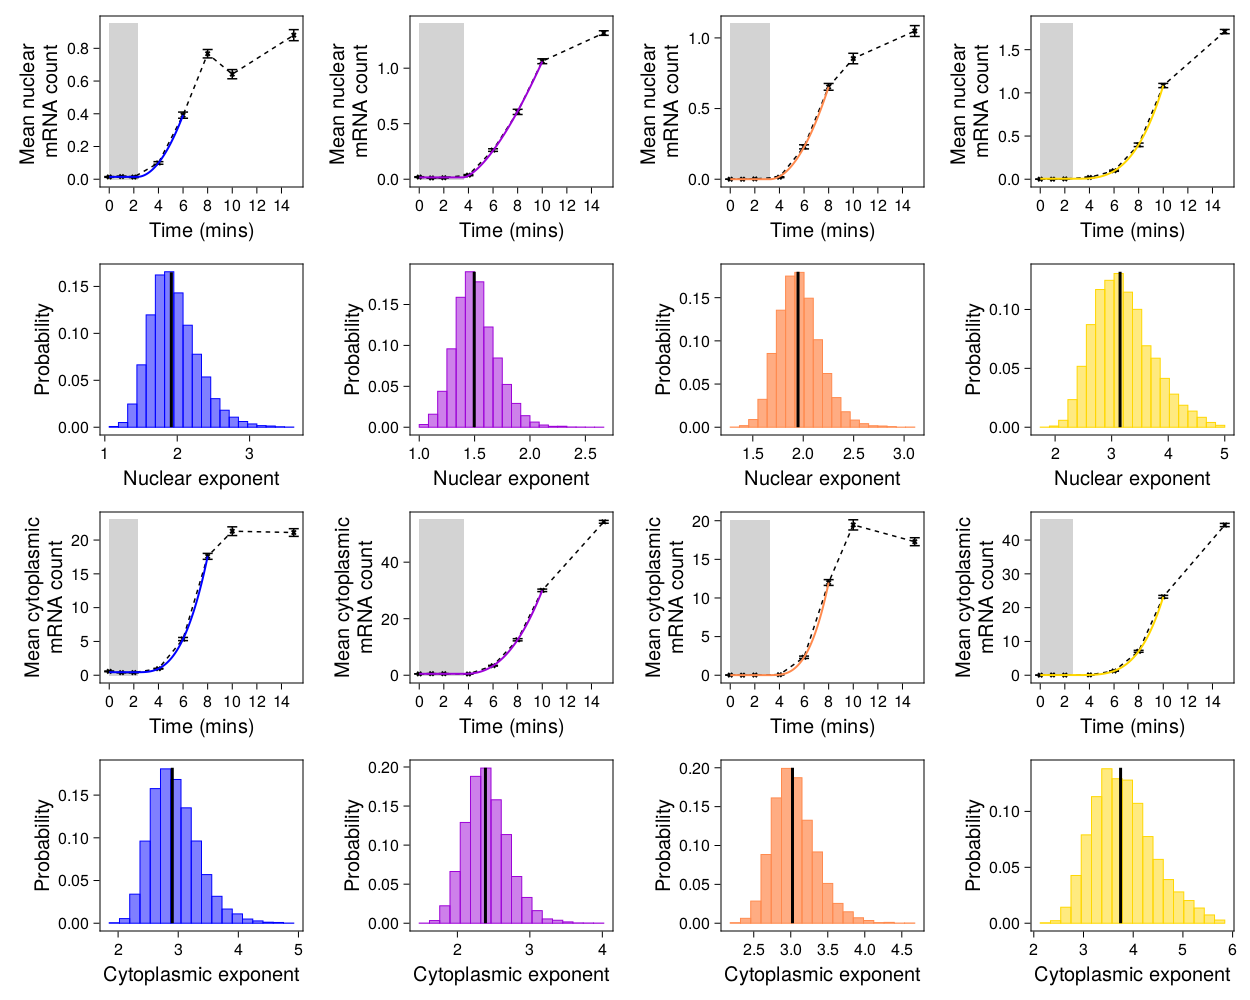

In [19]:
#Fig 5

#Figure options
color_vec = [bblue, ppurple, oorange, yyellow];
pale_color_vec = [bbblue, pppurple, ooorange, yyyellow];

delay_box_heights_N = [0.95, 1.4, 1.1, 1.8];
delay_box_heights_C = [23, 55, 20, 46];

nuclear_exponent_median_heights = [0.165, 0.19, 0.18, 0.132];
cytoplasm_exponent_median_heights = [0.182, 0.199, 0.2, 0.139];


fig_5 = Figure(resolution = 1.0.*(1250, 1000))

for data_idx in 1:1:4
    
    #nuclear curve
    ax = Axis(fig_5[1,data_idx], xlabel="Time (mins)", ylabel="Mean nuclear 
mRNA count",
              xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16, xticks=[0,2,4,6,8,10,12,14])
    
    #shading background grey during delay
    p1 = Point2(0.0, 0.0)
    p2 = Point2(0.0, delay_box_heights_N[data_idx])
    p3 = Point2(optimal_params_cytoplasm_all[data_idx][3], 0.0)
    p4 = Point2(optimal_params_cytoplasm_all[data_idx][3], delay_box_heights_N[data_idx])
    sc = mesh!(fig_5[1,data_idx], [p1, p2, p3], color = :lightgrey, shading = false)
    mesh!(fig_5[1,data_idx], [p2, p4, p3], color = :lightgrey, shading = false)
    
    #plot mean nuclear mRNA induction curve
    CairoMakie.scatterlines!(times_vec, nuclear_means_vec_all[data_idx][1:8], color=:black, marker=:xcross, markersize=8, linewidth=1.5,
        linestyle=:dash)
    #error bars
    errorbars!(times_vec, nuclear_means_vec_all[data_idx][1:8], nuclear_stderr_vec_all[data_idx][1:8], color=:black, whiskerwidth=10)   
    #regression
    CairoMakie.lines!(x_range_N_all[data_idx], nuclear_mean_reg_all[data_idx], color=color_vec[data_idx], linewidth=2)
    hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
    
    #nuclear exponent distribution
    ax = Axis(fig_5[2,data_idx], xlabel="Nuclear exponent", ylabel="Probability",
              xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16)
    CairoMakie.hist!(ax, n_N_vec_all[data_idx], bins=20, normalization=:probability, strokewidth = 1, strokecolor=color_vec[data_idx],
        color=pale_color_vec[data_idx])
    #plot median line
    CairoMakie.lines!([percentiles_n_N_all[data_idx][3], percentiles_n_N_all[data_idx][3]],
        [0.0, nuclear_exponent_median_heights[data_idx]], color=:black, linewidth = 3)
    hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
    
    #cytoplasmic curve
    ax = Axis(fig_5[3,data_idx], xlabel="Time (mins)", ylabel="Mean cytoplasmic
mRNA count",
              xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16, xticks=[0,2,4,6,8,10,12,14])
    
    #shading background grey during delay
    p1 = Point2(0.0, 0.0)
    p2 = Point2(0.0, delay_box_heights_C[data_idx])
    p3 = Point2(optimal_params_cytoplasm_all[data_idx][3], 0.0)
    p4 = Point2(optimal_params_cytoplasm_all[data_idx][3], delay_box_heights_C[data_idx])
    sc = mesh!(fig_5[3,data_idx], [p1, p2, p3], color = :lightgrey, shading = false)
    mesh!(fig_5[3,data_idx], [p2, p4, p3], color = :lightgrey, shading = false)
    
    #pot mean cytoplasmic mRNA induction curve
    CairoMakie.scatterlines!(times_vec, cytoplasm_means_vec_all[data_idx][1:8], color=:black, marker=:xcross, markersize=8, linewidth=1.5,
        linestyle=:dash)
    #error bars
    errorbars!(times_vec[1:8], cytoplasm_means_vec_all[data_idx][1:8], cytoplasm_stderr_vec_all[data_idx][1:8], color=:black, whiskerwidth=10)   
    #regression
    CairoMakie.lines!(x_range_C_all[data_idx], cytoplasm_mean_reg_all[data_idx], color=color_vec[data_idx], linewidth=2)
    hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
    
    #cytoplasmic exponent distribution
    ax = Axis(fig_5[4,data_idx], xlabel="Cytoplasmic exponent", ylabel="Probability",
              xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16)
    CairoMakie.hist!(ax, n_C_vec_all[data_idx], bins=18, normalization=:probability, strokewidth = 1, strokecolor=color_vec[data_idx],
        color=pale_color_vec[data_idx])
    #plot median line
    CairoMakie.lines!([percentiles_n_C_all[data_idx][3], percentiles_n_C_all[data_idx][3]],
        [0.0, cytoplasm_exponent_median_heights[data_idx]], color=:black, linewidth = 3)
    hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
    
end

fig_5

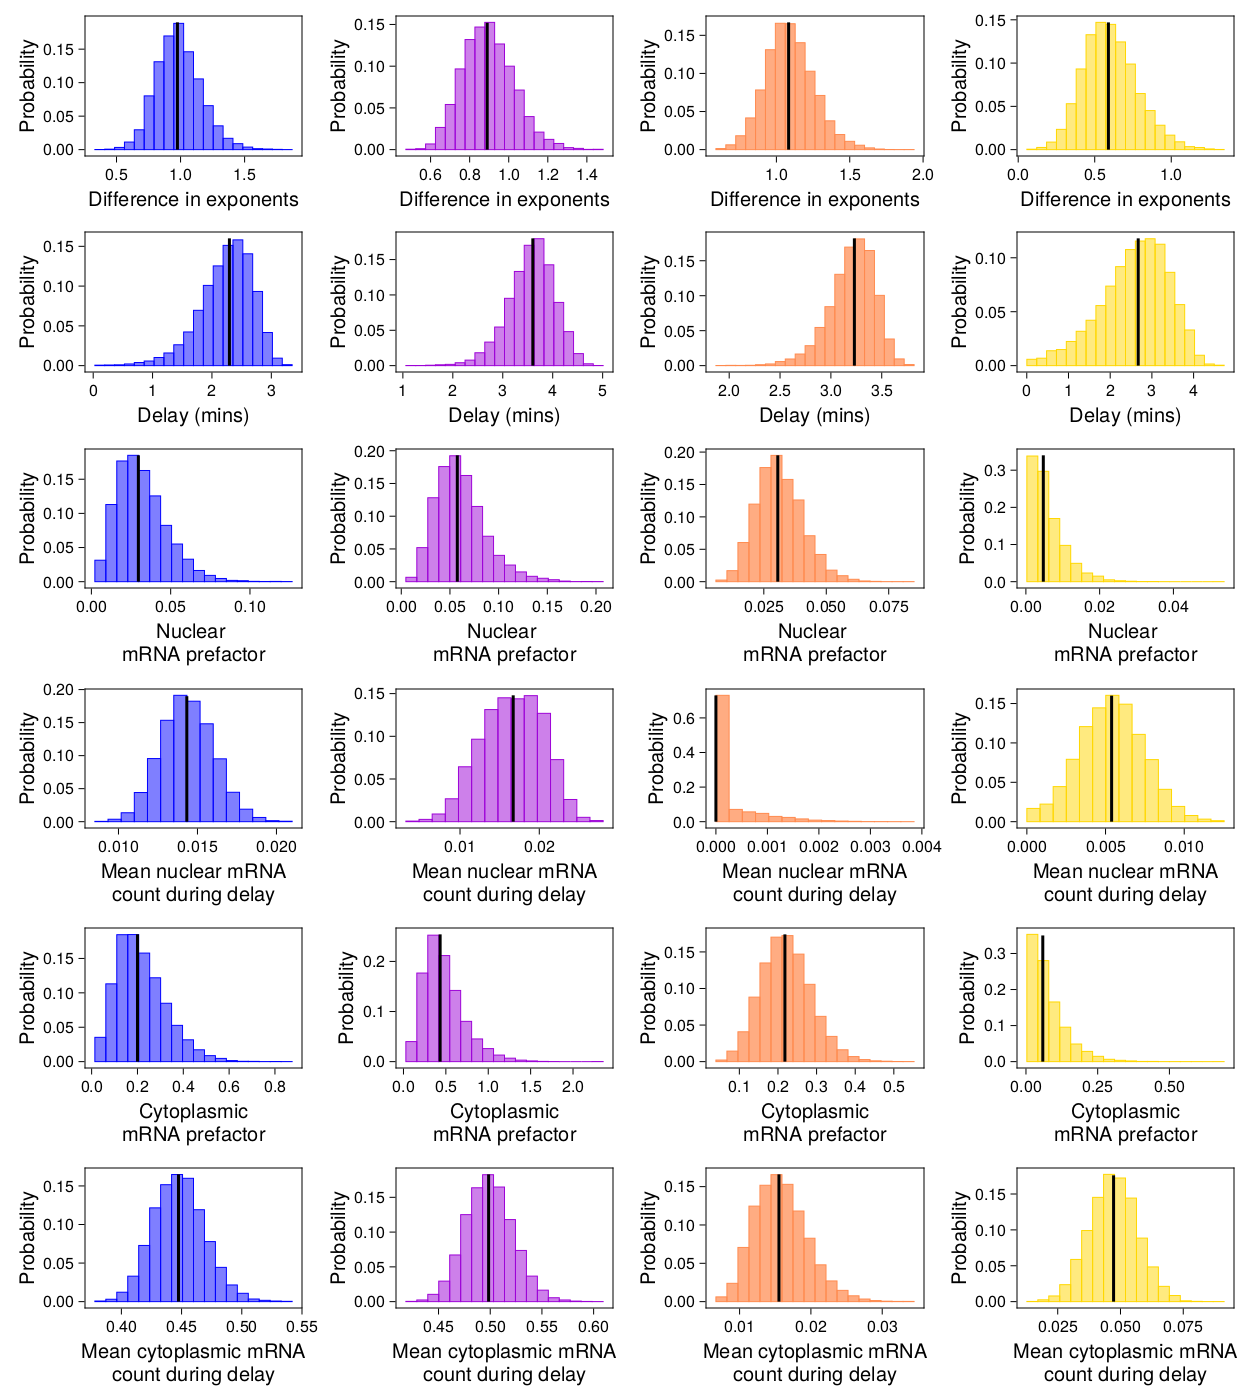

In [20]:
#Fig S11

#Figure options
color_vec = [bblue, ppurple, oorange, yyellow];
pale_color_vec = [bbblue, pppurple, ooorange, yyyellow];

diffinexp_median_heights = [0.19, 0.152, 0.167, 0.147]
delay_median_heights = [0.16, 0.18, 0.182, 0.118];
nuclear_prefactor_median_heights = [0.185, 0.193, 0.195, 0.34];
cytoplasm_prefactor_median_heights = [0.185, 0.254, 0.174, 0.35];
nuclear_meandelay_median_heights = [0.19, 0.148, 0.73, 0.16];
cytoplasm_meandelay_median_heights = [0.165, 0.183, 0.166, 0.176];


fig_S11 = Figure(resolution = 1.0.*(1250, 1400))

for data_idx in 1:1:4
    
    #exponent difference distribution
    ax = Axis(fig_S11[1,data_idx], xlabel="Difference in exponents", ylabel="Probability",
              xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16)
    CairoMakie.hist!(ax, n_C_vec_all[data_idx].-n_N_vec_all[data_idx], bins=20, normalization=:probability, strokewidth = 1,
        strokecolor=color_vec[data_idx], color=pale_color_vec[data_idx])
    #median line
    CairoMakie.lines!([percentiles_diffnCnN_all[data_idx][3], percentiles_diffnCnN_all[data_idx][3]],
        [0.0, diffinexp_median_heights[data_idx]], color=:black, linewidth = 3)
    hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
    
    #delay distribution
    ax = Axis(fig_S11[2,data_idx], xlabel="Delay (mins)", ylabel="Probability",
              xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16)
    CairoMakie.hist!(ax, t0_vec_all[data_idx], bins=20, normalization=:probability, strokewidth = 1, strokecolor=color_vec[data_idx],
        color=pale_color_vec[data_idx])
    #median line
    CairoMakie.lines!([percentiles_t0_all[data_idx][3], percentiles_t0_all[data_idx][3]],
        [0.0, delay_median_heights[data_idx]], color=:black, linewidth = 3)
    hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
    
    #nuclear prefactor - A_N
    nbins=18;
    ax = Axis(fig_S11[3,data_idx], xlabel="Nuclear 
mRNA prefactor", ylabel="Probability",
              xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16)
    CairoMakie.hist!(ax, A_N_vec_all[data_idx], bins=nbins, normalization=:probability, strokewidth = 1, strokecolor=color_vec[data_idx],
        color=pale_color_vec[data_idx])
    CairoMakie.lines!([percentiles_A_N_all[data_idx][3], percentiles_A_N_all[data_idx][3]],
        [0.0, nuclear_prefactor_median_heights[data_idx]], color=:black, linewidth = 3)
    hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
    
    #constant nuclear mRNA count during delay - m0_N
    nbins=15;
    if data_idx==2
        ax = Axis(fig_S11[4,data_idx], xlabel="Mean nuclear mRNA
count during delay", ylabel="Probability",
              xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16, xticks=[0.01, 0.02, 0.03])
    else
        ax = Axis(fig_S11[4,data_idx], xlabel="Mean nuclear mRNA
count during delay", ylabel="Probability",
              xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16)
    end
    CairoMakie.hist!(ax, m0N_vec_all[data_idx], bins=nbins, normalization=:probability, strokewidth = 1, strokecolor=color_vec[data_idx],
        color=pale_color_vec[data_idx])
    #median line
    CairoMakie.lines!([percentiles_m0N_all[data_idx][3], percentiles_m0N_all[data_idx][3]],
        [0.0, nuclear_meandelay_median_heights[data_idx]], color=:black, linewidth = 3)
    hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
    
    #cytoplasmic prefactor - A_C
    nbins=18;
    ax = Axis(fig_S11[5,data_idx], xlabel="Cytoplasmic
mRNA prefactor", ylabel="Probability",
              xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16)
    CairoMakie.hist!(ax, A_C_vec_all[data_idx], bins=nbins, normalization=:probability, strokewidth = 1, strokecolor=color_vec[data_idx],
        color=pale_color_vec[data_idx])
    #median line
    CairoMakie.lines!([percentiles_A_C_all[data_idx][3], percentiles_A_C_all[data_idx][3]],
        [0.0, cytoplasm_prefactor_median_heights[data_idx]], color=:black, linewidth = 3)
    hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
    
    #constant cytoplasmic mRNA count during delay - m0_C
    ax = Axis(fig_S11[6,data_idx], xlabel="Mean cytoplasmic mRNA
count during delay", ylabel="Probability",
              xlabelsize=20, xticklabelsize=16, ylabelsize=20, yticklabelsize=16)
    CairoMakie.hist!(ax, m0C_vec_all[data_idx], bins=18, normalization=:probability, strokewidth = 1, strokecolor=color_vec[data_idx],
        color=pale_color_vec[data_idx])
    #median line
    CairoMakie.lines!([percentiles_m0C_all[data_idx][3], percentiles_m0C_all[data_idx][3]],
        [0.0, cytoplasm_meandelay_median_heights[data_idx]], color=:black, linewidth = 3)
    hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
    
end

fig_S11